In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re
import pickle


from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
RANDOM_STATE = 42

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('train.csv')

In [4]:
df.isnull().sum()

ID                                    0
hotel                                 0
is_canceled                           0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              4
babies                                0
meal                                  0
country                             468
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                             13217


In [5]:
df = df.drop(columns=['ID'])
df['agent'] = df['agent'].fillna('No_Agent')
df['company'] = df['company'].fillna('No_Company')
df.dropna(subset=['children'], inplace=True)
df['country'].fillna("unknown", inplace=True)
df['children'] = df['children'].astype(int)
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['hotel'] = np.where(df['hotel']=='City Hotel',1,0)

In [6]:
df.isnull().sum().sum()

0

In [7]:
df.dtypes

hotel                                      int64
is_canceled                                int64
lead_time                                  int64
arrival_date_year                          int64
arrival_date_month                        object
arrival_date_week_number                   int64
arrival_date_day_of_month                  int64
stays_in_weekend_nights                    int64
stays_in_week_nights                       int64
adults                                     int64
children                                   int64
babies                                     int64
meal                                      object
country                                   object
market_segment                            object
distribution_channel                      object
is_repeated_guest                          int64
previous_cancellations                     int64
previous_bookings_not_canceled             int64
reserved_room_type                        object
assigned_room_type  

In [8]:
df['arrival_date_full'] = df['arrival_date_year'].astype(str) + "-" + df['arrival_date_month'].map({'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12}).astype(str) + "-" + df['arrival_date_day_of_month'].astype(str)
df['arrival_date_full'] = pd.to_datetime(df['arrival_date_full'], format="%Y-%m-%d")

In [27]:
df['status_minus_arrival_date'] = np.abs(df['arrival_date_full'] - df['reservation_status_date']).astype(str)
df['status_minus_arrival_date']

# def format_lenght(date):
#     return date[0]
# df['status_minus_arrival_date'] = df['status_minus_arrival_date'].map(format_lenght).astype(int)


0          0 days 00:00:00.000000000
1          2 days 00:00:00.000000000
2          2 days 00:00:00.000000000
3          2 days 00:00:00.000000000
4          2 days 00:00:00.000000000
5          2 days 00:00:00.000000000
6          2 days 00:00:00.000000000
7          2 days 00:00:00.000000000
8          2 days 00:00:00.000000000
9          2 days 00:00:00.000000000
10         2 days 00:00:00.000000000
11         2 days 00:00:00.000000000
12         2 days 00:00:00.000000000
13         2 days 00:00:00.000000000
14         2 days 00:00:00.000000000
15         2 days 00:00:00.000000000
16         2 days 00:00:00.000000000
17         2 days 00:00:00.000000000
18         2 days 00:00:00.000000000
19         2 days 00:00:00.000000000
20         2 days 00:00:00.000000000
21         2 days 00:00:00.000000000
22         2 days 00:00:00.000000000
23        15 days 00:00:00.000000000
24        15 days 00:00:00.000000000
25        15 days 00:00:00.000000000
26        15 days 00:00:00.000000000
2

In [11]:
X = df.drop(columns=['is_canceled', 'reservation_status', 'agent', 'company', 'country', 'reservation_status_date', 'arrival_date_full'])

X.head()

hotel  lead_time  arrival_date_year arrival_date_month  \
0      0        342               2015               July   
1      1        257               2015               July   
2      1        257               2015               July   
3      1        257               2015               July   
4      1        257               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     0       2         0       0   
1                        0                     2       1         0       0   
2                        0                     2       2         0       0   
3                        0                     2       2         0       0   
4                        0                     2       2         0       0   

  meal market_segment distribution_channel  is_repeated_guest  \
0   BB         Direct               Direct                  0   
1   HB  Offline TA/TO                TA/TO                  0   
2   HB  Offline TA/TO                TA/TO                  0   
3   HB  Offline TA/TO                TA/TO                  0   
4   HB  Offline TA/TO                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  C   
1                       0                               0                  A   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

  assigned_room_type  booking_changes deposit_type  days_in_waiting_list  \
0                  C                3   No Deposit                     0   
1                  A                1   No Deposit                     0   
2                  A                0   No Deposit                     0   
3                  A                0   No Deposit                     0   
4                  A                0   No Deposit                     0   

  customer_type        adr  required_car_parking_spaces  \
0     Transient  -6.305161                            0   
1     Transient  75.052227                            0   
2     Transient  74.546401                            0   
3     Transient  76.376288                            0   
4     Transient  49.411647                            0   

   total_of_special_requests  status_minus_arrival_date  
0                          0                          0  
1                          0                          2  
2                          0                          2  
3                          0                          2  
4                          0                          2

In [13]:
kproto_4 = KPrototypes(n_clusters=4, init='Huang', verbose=0, random_state=RANDOM_STATE, n_jobs=-1)
clusters = kproto_4.fit_predict(X, categorical=[3, 11, 12, 13, 14, 17, 18, 20, 22, 26])
print(f'cost: {kproto_4.cost_}')

cost: 412571916.24963945


In [24]:
df['clusters'] = clusters
pd.set_option('display.max_rows', None)
df.groupby(df['clusters']).describe(include='all').T

clusters                                                  0  \
hotel                           count                 11326   
                                unique                  NaN   
                                top                     NaN   
                                freq                    NaN   
                                first                   NaN   
                                last                    NaN   
                                mean                0.75234   
                                std                0.431672   
                                min                       0   
                                25%                       1   
                                50%                       1   
                                75%                       1   
                                max                       1   
is_canceled                     count                 11326   
                                unique                  NaN   
                                top                     NaN   
                                freq                    NaN   
                                first                   NaN   
                                last                    NaN   
                                mean               0.682412   
                                std                0.465559   
                                min                       0   
                                25%                       0   
                                50%                       1   
                                75%                       1   
                                max                       1   
lead_time                       count                 11326   
                                unique                  NaN   
                                top                     NaN   
                                freq                    NaN   
                                first                   NaN   
                                last                    NaN   
                                mean                318.728   
                                std                  73.729   
                                min                     206   
                                25%                     270   
                                50%                     300   
                                75%                     344   
                                max                     737   
arrival_date_year               count                 11326   
                                unique                  NaN   
                                top                     NaN   
                                freq                    NaN   
                                first                   NaN   
                                last                    NaN   
                                mean                2015.74   
                                std                0.554616   
                                min                    2015   
                                25%                    2015   
                                50%                    2016   
                                75%                    2016   
                                max                    2017   
arrival_date_week_number        count                 11326   
                                unique                  NaN   
                                top                     NaN   
                                freq                    NaN   
                                first                   NaN   
                                last                    NaN   
                                mean                33.7603   
                                std                 10.7286   
                                min                       1   
                                25%                      28   
                               

In [26]:
df['clusters'] = df['clusters'].map({0:'The Family', 1:'The Return Customer', 2:'The Cancellation Squad', 3:'The Extended Stay'})

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
5        NaN
6        NaN
7        NaN
8        NaN
9        NaN
10       NaN
11       NaN
12       NaN
13       NaN
14       NaN
15       NaN
16       NaN
17       NaN
18       NaN
19       NaN
20       NaN
21       NaN
22       NaN
23       NaN
24       NaN
25       NaN
26       NaN
27       NaN
28       NaN
29       NaN
30       NaN
31       NaN
32       NaN
33       NaN
34       NaN
35       NaN
36       NaN
37       NaN
38       NaN
39       NaN
40       NaN
41       NaN
42       NaN
43       NaN
44       NaN
45       NaN
46       NaN
47       NaN
48       NaN
49       NaN
50       NaN
51       NaN
52       NaN
53       NaN
54       NaN
55       NaN
56       NaN
57       NaN
58       NaN
59       NaN
60       NaN
61       NaN
62       NaN
63       NaN
64       NaN
65       NaN
66       NaN
67       NaN
68       NaN
69       NaN
70       NaN
71       NaN
72       NaN
73       NaN
74       NaN
75       NaN
76       NaN

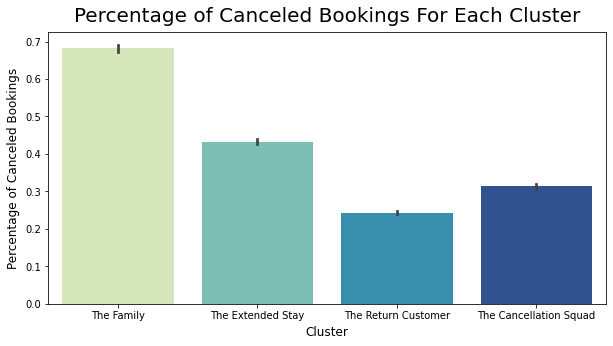

In [16]:
plt.figure(figsize=(10,5)) 
plt.title("Percentage of Canceled Bookings For Each Cluster", fontsize = 20, pad = 10)
sns.barplot(x=df['clusters'], y=df['is_canceled'], palette='YlGnBu')
plt.xlabel("Cluster", fontsize = 12, labelpad = 5)
plt.ylabel("Percentage of Canceled Bookings", fontsize = 12, labelpad = 5);

In [17]:
df = pd.get_dummies(df, columns=['arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'clusters'])
df.head()

hotel  is_canceled  lead_time  arrival_date_year  arrival_date_week_number  \
0      0            0        342               2015                        27   
1      1            0        257               2015                        27   
2      1            0        257               2015                        27   
3      1            0        257               2015                        27   
4      1            0        257               2015                        27   

   arrival_date_day_of_month  stays_in_weekend_nights  stays_in_week_nights  \
0                          1                        0                     0   
1                          1                        0                     2   
2                          1                        0                     2   
3                          1                        0                     2   
4                          1                        0                     2   

   adults  children  babies country  is_repeated_guest  \
0       2         0       0     PRT                  0   
1       1         0       0     PRT                  0   
2       2         0       0     PRT                  0   
3       2         0       0     PRT                  0   
4       2         0       0     PRT                  0   

   previous_cancellations  previous_bookings_not_canceled  booking_changes  \
0                       0                               0                3   
1                       0                               0                1   
2                       0                               0                0   
3                       0                               0                0   
4                       0                               0                0   

      agent     company  days_in_waiting_list        adr  \
0  No_Agent  No_Company                     0  -6.305161   
1         6  No_Company                     0  75.052227   
2         6  No_Company                     0  74.546401   
3         6  No_Company                     0  76.376288   
4         6  No_Company                     0  49.411647   

   required_car_parking_spaces  total_of_special_requests reservation_status  \
0                            0                          0          Check-Out   
1                            0                          0          Check-Out   
2                            0                          0          Check-Out   
3                            0                          0          Check-Out   
4                            0                          0          Check-Out   

  reservation_status_date arrival_date_full  status_minus_arrival_date  \
0              2015-07-01        2015-07-01                          0   
1              2015-07-03        2015-07-01                          2   
2              2015-07-03        2015-07-01                          2   
3              2015-07-03        2015-07-01                          2   
4              2015-07-03        2015-07-01                          2   

   arrival_date_month_April  arrival_date_month_August  \
0                         0                          0   
1                         0                          0   
2                         0                          0   
3                         0                          0   
4                         0                          0   

   arrival_date_month_December  arrival_date_month_February  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   arrival_date_month_January  arrival_date_month_July  \
0                           0                        1   
1                           0                        1   
2                           0     

In [18]:
X = df.drop(columns=['is_canceled','reservation_status', 'agent', 'company', 'country', 
                     'reservation_status_date', 'arrival_date_full'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, 
                                                    stratify=y, test_size=0.15)

In [19]:
dt_params = {
    'max_depth':[None],
    'max_features' : [0.7],
    'min_samples_split': [25], 
    'min_samples_leaf': [1]
}

# Perform Grid Search
dt_gs = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE),
                 dt_params,
                 cv = 5,
                 scoring = 'accuracy')
dt = dt_gs.fit(X_train, y_train)

In [20]:
print(f'Best Training Accuracy: {dt.score(X_train, y_train)}')
print(f'Best Testing Accuracy: {dt.score(X_test, y_test)}')
print(f'Cross-val-score: {cross_val_score(dt.best_estimator_, X, y, cv=StratifiedKFold(shuffle=True)).mean()}')

Best Training Accuracy: 0.9616823270820212
Best Testing Accuracy: 0.9326292789512017
Cross-val-score: 0.9390235175586309
